In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from sklearn import preprocessing
import numpy as np
from finta import TA
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers
from keras.callbacks import History
from sklearn.metrics import mean_squared_error
import random as python_random

ModuleNotFoundError: No module named 'tensorflow.compat'

In [102]:
def train_test_split_preparation(new_df, data_set_points, train_split):
    # Ensure there's no missing data at the beginning
    new_df = new_df.dropna().reset_index(drop=True)

    # Calculate the index for splitting the data
    train_indices = int(len(new_df) * train_split)

    # Split the data into training and testing sets
    train_data = new_df.iloc[:train_indices]
    test_data = new_df.iloc[train_indices:]

    # Calculate the differences between consecutive elements in 'Adj Close' prices --> done in time series analysis to transform the data into a stationary series
    train_diff = np.diff(train_data['Adj Close'].values, axis=0)
    test_diff = np.diff(test_data['Adj Close'].values, axis=0)

    # Prepare the training and testing data
    x_train = np.array([train_diff[i: i + data_set_points] for i in range(len(train_diff) - data_set_points)])
    y_train = train_diff[data_set_points:]

    x_test = np.array([test_diff[i: i + data_set_points] for i in range(len(test_diff) - data_set_points)])
    y_test = test_diff[data_set_points:]

    return x_train, y_train, x_test, y_test, test_data

In [103]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

def lstm_model(X_train, y_train, data_set_points):
    tf.random.set_seed(42)
    np.random.seed(42)
    python_random.seed(42)

    lstm_input = Input(shape=(data_set_points, 1))

    inputs = LSTM(21, return_sequences=True)(lstm_input)
    inputs = Dropout(0.1)(inputs)
    inputs = LSTM(32)(inputs)
    inputs = Dropout(0.05)(inputs)
    inputs = Dense(32)(inputs)
    output = Dense(1, activation='linear')(inputs)

    model = Model(inputs=lstm_input, outputs=output)

    # Learning rate schedule --> Instead of using a fixed learning rate, using a learning rate schedule to adjust the learning rate during training
    # lr_schedule = tf.optimizers.schedules.ExponentialDecay(
    #     initial_learning_rate=0.002,
    #     decay_steps=10000,
    #     decay_rate=0.9)
    # adam = tf.optimizers.Adam(learning_rate=lr_schedule)
    model = Model(inputs=lstm_input, outputs=output)
    adam = optimizers.Adam(lr = 0.002)

    model.compile(optimizer=adam, loss='mse', metrics=['mae'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss',
                                       save_best_only=True)  # save the model at its best state during training

    model.fit(x=X_train, y=y_train, batch_size=15, epochs=25, shuffle=True, validation_split=0.1,
              callbacks=[early_stopping, model_checkpoint])

    return model

In [104]:
def generate_predicted_result_based_on_previous_actual(actual, y_pred):
    """
    Generates and plots the predicted stock prices based on the actual prices and predicted differences.
    Also calculates and prints the RMSE between the actual and predicted prices.

    Parameters:
    actual (numpy.ndarray): The actual stock prices.
    y_pred (numpy.ndarray): The predicted differences in stock prices.

    Returns:
    None
    """
    # Adding each actual price at time t with the predicted difference to get a predicted price at time t + 1
    predicted_prices = np.add(actual[:-1], y_pred)

    # Plot settings
    plt.figure(figsize=(12, 8))
    plt.title('Actual vs Predicted Stock Prices')
    plt.xlabel('Number of Days')
    plt.ylabel('Adjusted Close Price ($)')

    # Plotting actual and predicted prices
    plt.plot(actual[1:], label='Actual Price', color='blue')
    plt.plot(predicted_prices, label='Predicted Price', color='red')

    # Calculating and printing RMSE
    rmse = mean_squared_error(actual[1:], predicted_prices, squared=False)
    print("RMSE:", rmse)

    plt.legend()
    plt.show()

In [105]:
start_date = datetime(2020, 12, 20).strftime('%Y-%m-%d')
end_date = datetime(2023, 12, 20).strftime('%Y-%m-%d')

In [106]:
stock_df = yf.download("AAPL", start=start_date, end=end_date)
# print(stock_df.head())

[*********************100%%**********************]  1 of 1 completed


Epoch 1/25


2024-01-03 19:14:34.469225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-03 19:14:34.470059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-03 19:14:34.470642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/31 [========================>.....] - ETA: 0s - loss: 7.9293 - mae: 2.1107

2024-01-03 19:14:36.452325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-03 19:14:36.453084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-03 19:14:36.453624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - 2s 18ms/step - loss: 7.9544 - mae: 2.1357 - val_loss: 9.3195 - val_mae: 2.2454
Epoch 2/25
31/31 [==============================] - 0s 6ms/step - loss: 7.9337 - mae: 2.1272 - val_loss: 9.2218 - val_mae: 2.2412
Epoch 3/25
31/31 [==============================] - 0s 5ms/step - loss: 7.8894 - mae: 2.1264 - val_loss: 9.3467 - val_mae: 2.2451
Epoch 4/25
31/31 [==============================] - 0s 5ms/step - loss: 7.8709 - mae: 2.1245 - val_loss: 9.2587 - val_mae: 2.2433
Epoch 5/25
31/31 [==============================] - 0s 6ms/step - loss: 7.8351 - mae: 2.1178 - val_loss: 9.2613 - val_mae: 2.2470
Epoch 6/25
31/31 [==============================] - 0s 6ms/step - loss: 7.8607 - mae: 2.1195 - val_loss: 9.2060 - val_mae: 2.2528
Epoch 7/25
31/31 [==============================] - 0s 6ms/step - loss: 7.8304 - mae: 2.1234 - val_loss: 9.1901 - val_mae: 2.2479
Epoch 8/25
31/31 [==============================] - 0s 6ms/step - loss: 7.8158 - mae: 2.1214 - val_l

2024-01-03 19:14:40.967806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-03 19:14:40.968450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-03 19:14:40.968936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

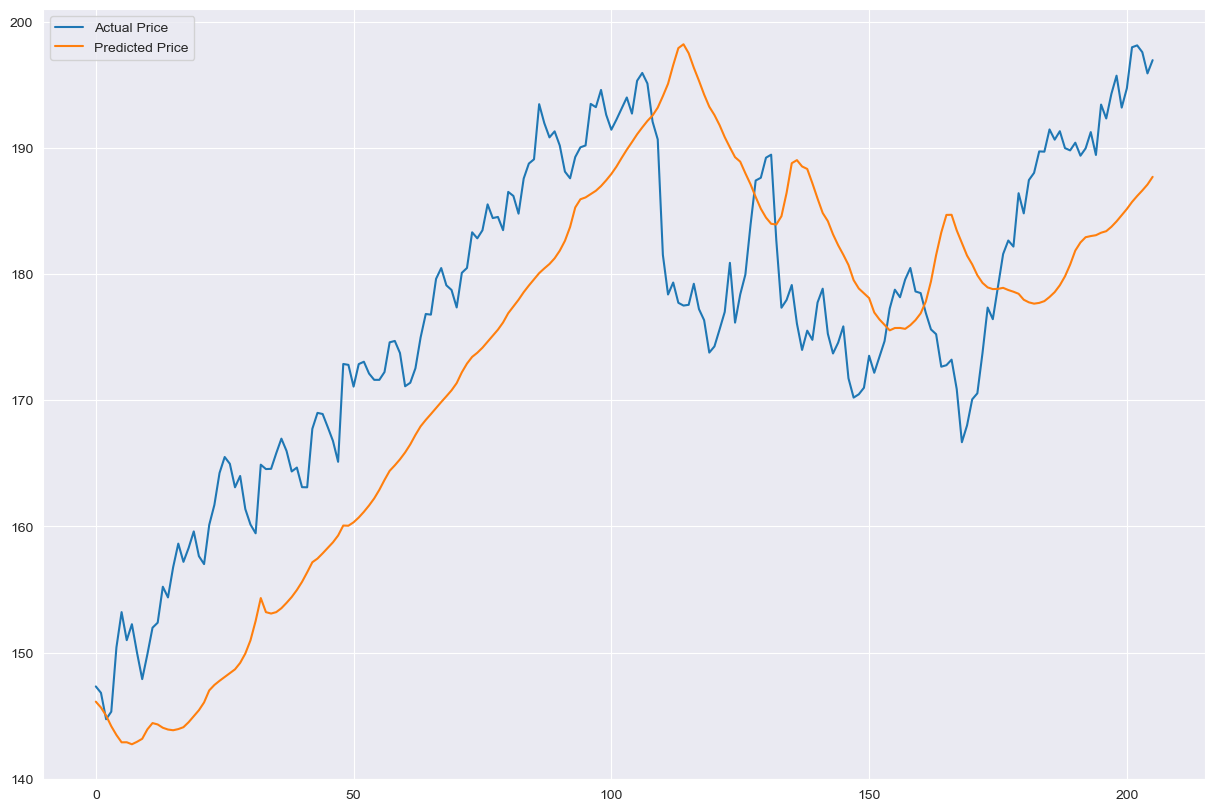

ValueError: Found input variables with inconsistent numbers of samples: [206, 205]

In [107]:
def plot_predictions(actual, predicted):
    plt.plot(actual, label='Actual Price')
    plt.plot(predicted, label='Predicted Price')
    plt.legend(['Actual Price', 'Predicted Price'])
    plt.gcf().set_size_inches(15, 10, forward=True)
    plt.show()

if __name__ == "__main__":
    train_split = 0.7
    data_set_points = 21

    # Prepare the data
    new_df = stock_df[['Adj Close']].copy()
    x_train, y_train, X_test, y_test, test_data = train_test_split_preparation(new_df, data_set_points, train_split)

    # Train the model
    model = lstm_model(x_train, y_train, data_set_points)

    # Make predictions
    y_pred = model.predict(X_test).flatten()

    # Prepare actual prices for comparison
    actual_prices = test_data['Adj Close'].iloc[data_set_points:].to_numpy()

    # Calculate cumulative predicted changes
    predicted_prices = np.cumsum(np.insert(y_pred, 0, test_data['Adj Close'].iloc[data_set_points - 1]))

    # Plot actual vs predicted prices
    plot_predictions(actual_prices, predicted_prices)

    # Calculate and print RMSE
    rmse = mean_squared_error(actual_prices, predicted_prices[1:], squared=False)
    print("RMSE:", rmse)

    # Generate predicted results based on previous actual
    generate_predicted_result_based_on_previous_actual(actual_prices, y_pred)

In [108]:
goog = yf.download("GOOG", start=start_date, end=end_date)
#print(goog.head())

[*********************100%%**********************]  1 of 1 completed


Epoch 1/25


2024-01-03 19:15:43.340717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-03 19:15:43.341882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-03 19:15:43.342532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/31 [=========================>....] - ETA: 0s - loss: 5.7067 - mae: 1.7687

2024-01-03 19:15:45.410916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-03 19:15:45.411868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-03 19:15:45.412823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - 2s 35ms/step - loss: 5.6290 - mae: 1.7476 - val_loss: 4.6184 - val_mae: 1.5921
Epoch 2/25
31/31 [==============================] - 0s 6ms/step - loss: 5.6325 - mae: 1.7528 - val_loss: 4.5970 - val_mae: 1.5975
Epoch 3/25
31/31 [==============================] - 0s 6ms/step - loss: 5.6009 - mae: 1.7533 - val_loss: 4.6426 - val_mae: 1.6071
Epoch 4/25
31/31 [==============================] - 0s 5ms/step - loss: 5.5861 - mae: 1.7429 - val_loss: 4.6406 - val_mae: 1.6005
Epoch 5/25
31/31 [==============================] - 0s 5ms/step - loss: 5.5632 - mae: 1.7483 - val_loss: 4.6499 - val_mae: 1.5952
Epoch 6/25
31/31 [==============================] - 0s 5ms/step - loss: 5.5654 - mae: 1.7428 - val_loss: 4.7043 - val_mae: 1.5958
Epoch 7/25
31/31 [==============================] - 0s 5ms/step - loss: 5.5887 - mae: 1.7562 - val_loss: 4.6276 - val_mae: 1.5879
Epoch 8/25
31/31 [==============================] - 0s 5ms/step - loss: 5.5767 - mae: 1.7430 - val_l

2024-01-03 19:15:47.724653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-03 19:15:47.725157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-03 19:15:47.725986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Prediction:
[89.34999847 89.54474859 89.69268243 89.7946265  89.80459618 89.71739628
 89.54387397 89.38425521 89.22968481 89.14665071 89.16891799 89.22815795
 89.22711996 89.13510872 88.91096723 88.60632309 88.29664883 87.92809313
 87.60409924 87.27501153 86.9771215  86.80446133 86.76881178 86.79534698
 86.87074888 86.88691332 86.84520169 86.76918746 86.68902643 86.52015901
 86.38038145 86.29173728 86.26486044 86.19249483 86.06963018 86.015365
 86.04008636 86.10805201 86.16178989 86.20628711 86.21176547 86.2611821
 86.33747131 86.3202226  86.26260967 86.20267461 86.19524038 86.21184304
 86.26767324 86.30953274 86.28143856 86.23363502 86.07934709 85.79792736
 85.45051507 85.11447052 84.74639915 84.36065729 83.95039321 83.56277407
 83.16346194 82.85179974 82.66962659 82.50076194 82.32382513 82.18189248
 82.11063932 82.05783274 81.99474409 81.8957441  81.75362177 81.7223746
 81.76284244 81.83085544 81.86095752 81.86582868 81.85930191 81.80573315
 81.78255255 81.78333392 81.8718731  81.923

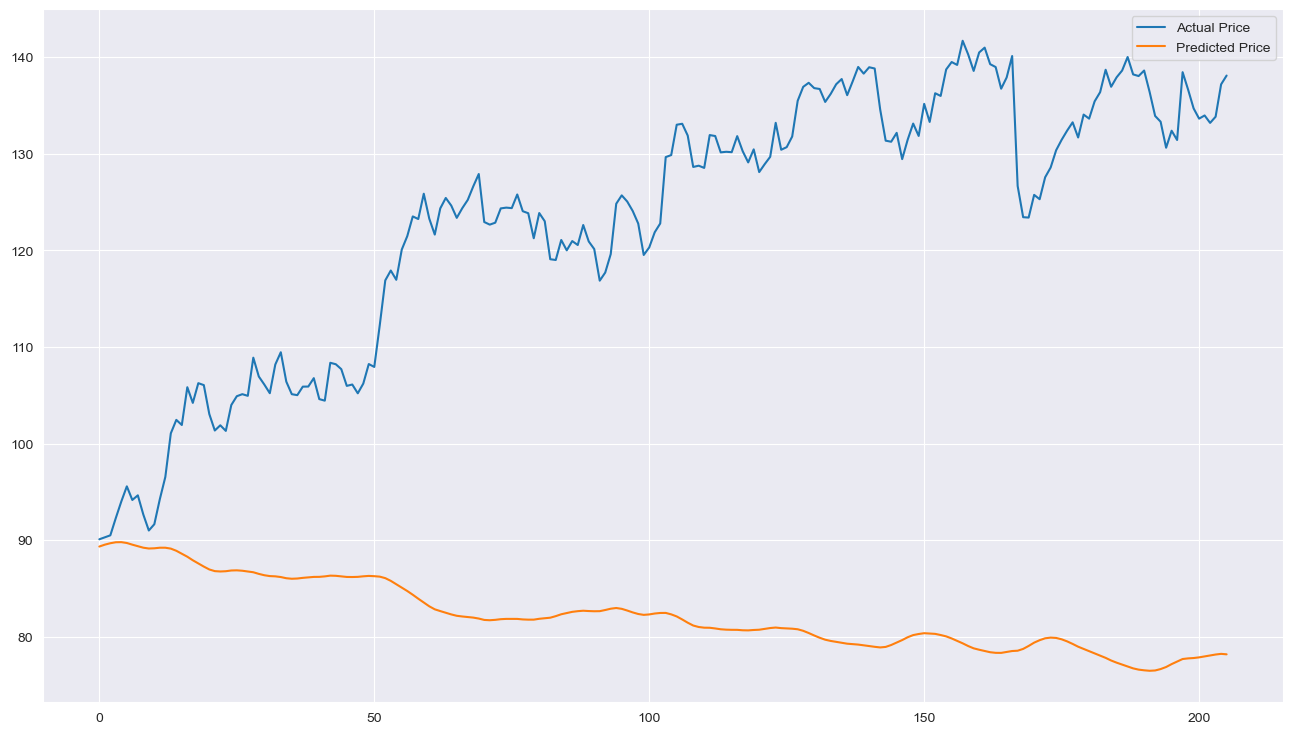

RMSE 2: 
4.7798042942029815
RMSE: 2.186276353575408


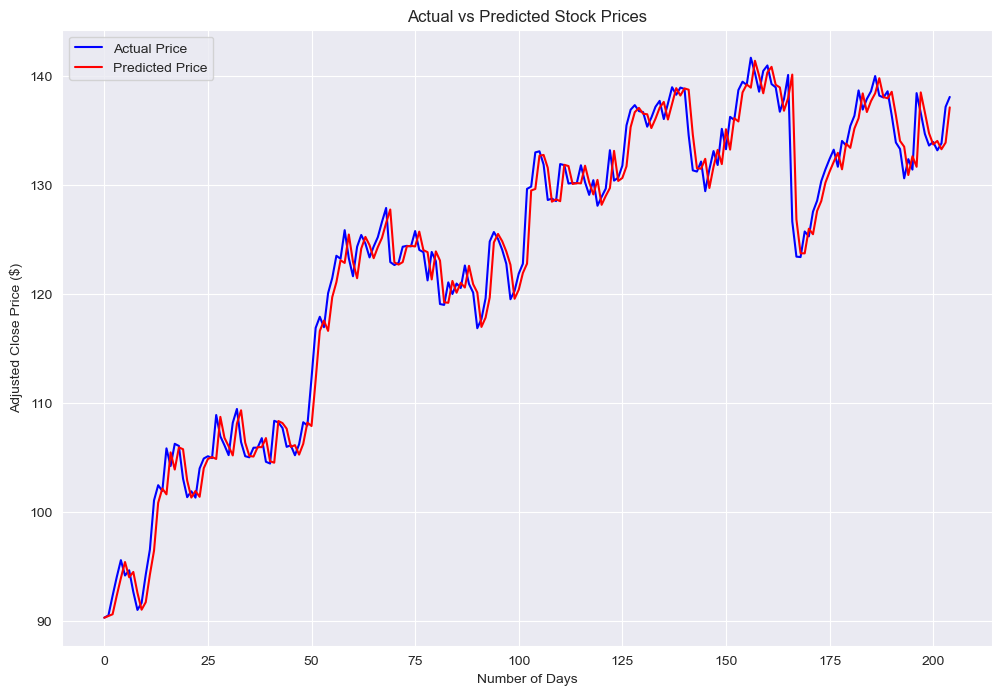

In [109]:
if __name__ == "__main__":
    #start_date = datetime(2013, 12, 20)
    #end_date = datetime(2023, 12, 20)

    train_split = 0.7

    data_set_points = 21

    new_df = goog[['Adj Close']].copy()

    #Train test split

    x_train, y_train, X_test, y_test, test_data = train_test_split_preparation(new_df, data_set_points, train_split)

    #Training of model
    model = lstm_model(x_train, y_train, data_set_points)

    #prediction of model
    y_pred = model.predict(X_test)

    y_pred = y_pred.flatten()

    #actual represents the test set's actual stock prices
    actual = np.array(
        [test_data['Adj Close'].iloc[i + data_set_points].copy() for i in range(len(test_data) - data_set_points)])

    #reference represents the stock price of the point before the prediction, so we can iteratively add the difference
    reference = test_data['Adj Close'].iloc[data_set_points - 1]

    predicted = [reference]
    for i in y_pred:
        reference += i
        predicted.append(reference)

    predicted = np.array(predicted)

    print("Prediction:")
    print(predicted)

    plt.plot(actual, label='Actual Price')
    plt.plot(predicted, label='Predicted Price')
    plt.legend(['Actual Price', 'Predicted Price'])
    plt.gcf().set_size_inches(16, 9, forward=True)
    plt.show()

    print("RMSE 2: ")
    print(mean_squared_error(y_test, y_pred))

    generate_predicted_result_based_on_previous_actual(actual, y_pred)